# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html

In [95]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, RobustScaler

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
DATASET_NAME = 'on-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

In [190]:
workdays = pd.read_csv(f'./data/workdays.csv', header=0, decimal=",")

workdays=workdays.rename(columns={"Workdays": "NumberWorkdays"})
workdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         626 non-null    object
 1   Year            626 non-null    int64 
 2   Week            626 non-null    int64 
 3   NumberWorkdays  626 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.7+ KB


In [97]:
data_dtype = {'SkuShort':'str', 'ProductGroup':'str', 'PrimaryPack':'str', 'Country':'str', 'IsLockdown':'bool'}

data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

# data_off_trade = pd.read_csv(f'./data/off-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data_on_trade = pd.read_csv(f'./data/on-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data = pd.concat([data_off_trade, data_on_trade], ignore_index=True)

data = data.sort_values(by=['Year','Week']).reset_index().drop(columns=['index'])

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01000,CLEAR BEER,TANK,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,1901.850666,2057.73,NaN,NaN,NaN,NaN,1902.0890
1,01002,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,472.938882,394.50,NaN,NaN,NaN,NaN,375.6472
2,01003,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,3010.971784,2535.60,NaN,NaN,NaN,NaN,2311.0085
3,01005,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,4930.067934,4515.50,NaN,NaN,NaN,NaN,4459.9005
4,01010,CLEAR BEER,KEG ONE WAY,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,46.150597,7.15,NaN,NaN,NaN,NaN,40.8850


In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25002 entries, 0 to 25001
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          25002 non-null  object 
 1   ProductGroup      25002 non-null  object 
 2   PrimaryPack       25002 non-null  object 
 3   Country           25002 non-null  object 
 4   Year              25002 non-null  int64  
 5   Week              25002 non-null  int64  
 6   NumberWorkdays    25002 non-null  int64  
 7   AvgTemp           25002 non-null  float64
 8   AvgRain           25002 non-null  float64
 9   AvgSun            25002 non-null  float64
 10  IsLockdown        25002 non-null  bool   
 11  PdtHl             479 non-null    float64
 12  PrevWeekPdtHl1    449 non-null    float64
 13  BgtHl             20233 non-null  float64
 14  SalesHl           25002 non-null  float64
 15  PrevWeekSalesHl1  24456 non-null  float64
 16  PrevWeekSalesHl2  24253 non-null  float6

In [99]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,25002.000000,25002.000000,25002.000000,25002.000000,25002.000000,25002.000000,479.000000,449.000000,20233.000000,25002.000000,24456.000000,24253.000000,18458.000000,13749.000000,23161.000000
mean,2018.157387,25.786497,4.787257,10.362729,1.676177,4.890909,32.313421,20.110566,757.496843,620.624621,377.808018,380.386378,461.394173,420.646117,642.398067
std,1.530272,15.039761,0.494658,7.721815,1.648968,2.984937,59.760659,34.993695,1484.212328,1473.285981,943.515589,946.969143,1063.198647,920.020846,1408.082133
min,2016.000000,1.000000,2.000000,-8.278571,0.000000,0.142857,0.300000,0.300000,0.000251,0.000000,0.000000,0.000000,0.000000,0.000000,0.053200
25%,2017.000000,13.000000,5.000000,4.000000,0.471429,2.164286,3.045784,2.781457,58.403662,30.000000,25.200000,25.800000,36.000000,39.000000,39.999200
50%,2018.000000,25.000000,5.000000,10.178571,1.142857,4.707143,13.037634,7.666667,214.440000,121.200000,79.200000,80.000000,108.600000,110.000000,150.470900
75%,2019.000000,39.000000,5.000000,17.707143,2.364286,7.135165,33.846154,28.889304,658.311358,486.300000,334.900000,336.910200,418.500000,415.500000,533.663400
max,2021.000000,53.000000,5.000000,25.814286,7.957143,13.864286,318.814035,318.814035,14379.048541,17816.500000,13487.500000,13487.500000,13487.500000,11801.000000,15049.836100


## Missing Values

In [100]:
data.isna().sum()

SkuShort                0
ProductGroup            0
PrimaryPack             0
Country                 0
Year                    0
Week                    0
NumberWorkdays          0
AvgTemp                 0
AvgRain                 0
AvgSun                  0
IsLockdown              0
PdtHl               24523
PrevWeekPdtHl1      24553
BgtHl                4769
SalesHl                 0
PrevWeekSalesHl1      546
PrevWeekSalesHl2      749
PrevYearSalesHl1     6544
PrevYearSalesHl2    11253
OldPredSalesHl       1841
dtype: int64

## Data Visualizations

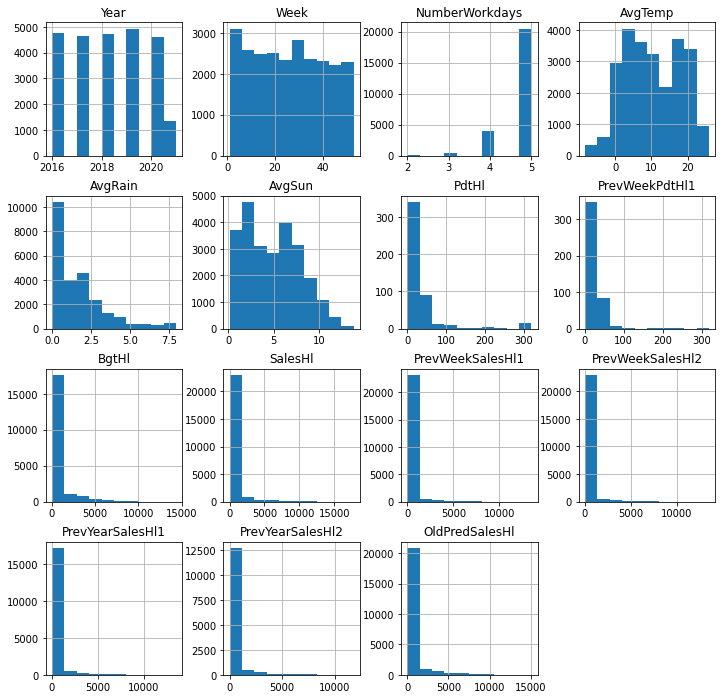

In [101]:
data.hist(figsize=[12,12])
plt.show()

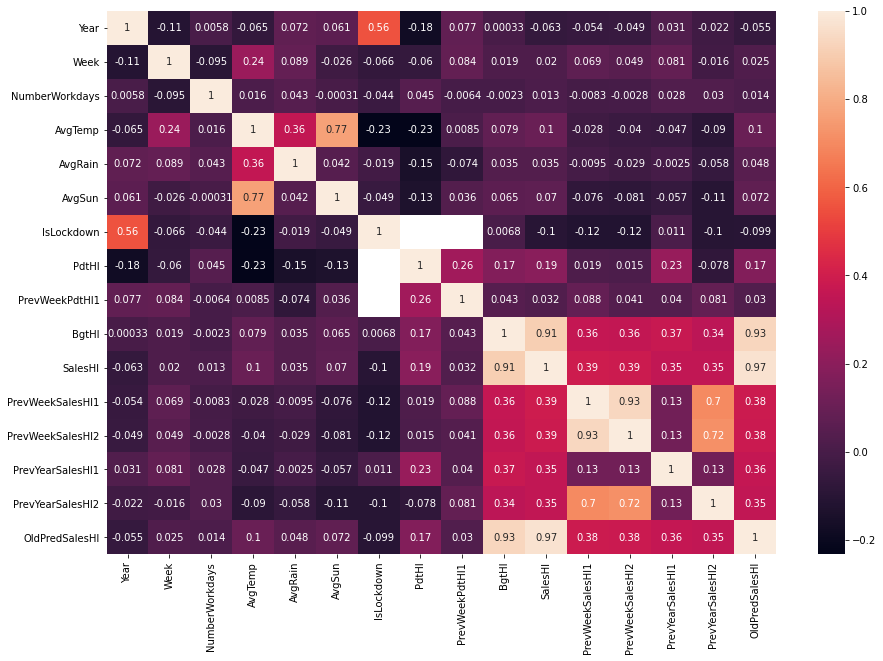

In [102]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

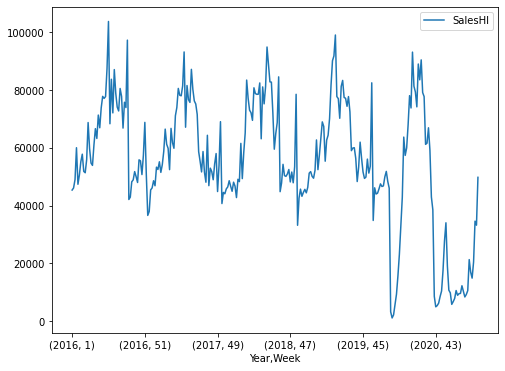

In [103]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

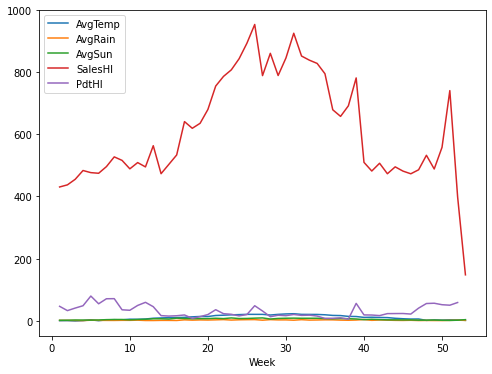

In [104]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

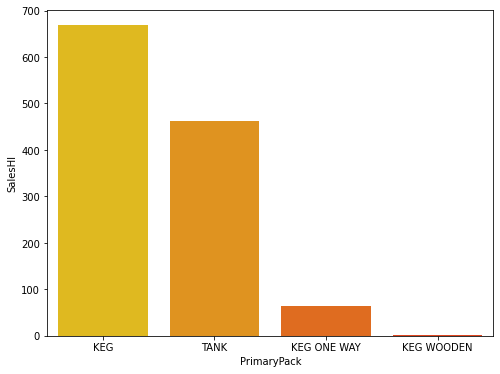

In [105]:
plt.figure(figsize=(8,6))
g_pps = data.groupby('PrimaryPack')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('PrimaryPack')
axis.set_ylabel('SalesHl')

plt.show()

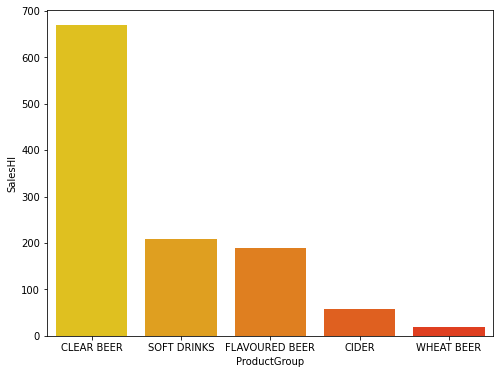

In [106]:
plt.figure(figsize=(8,6))
g_pgs = data.groupby('ProductGroup')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pgs.index, y=g_pgs, palette='autumn_r')
axis.set_xlabel('ProductGroup')
axis.set_ylabel('SalesHl')
plt.show()

In [107]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
OldPredSalesHl,0.970594
BgtHl,0.908401
PrevWeekSalesHl1,0.391503
PrevWeekSalesHl2,0.386546
PrevYearSalesHl2,0.354671
PrevYearSalesHl1,0.350015
PdtHl,0.191093
AvgTemp,0.100093
AvgSun,0.070498


## Skewness and Kurtesis

In [108]:
data.skew()

SkuShort            1.862407
Year                0.082610
Week                0.063349
NumberWorkdays     -2.652512
AvgTemp            -0.006154
AvgRain             1.555256
AvgSun              0.391067
IsLockdown          2.309615
PdtHl               3.573897
PrevWeekPdtHl1      5.327957
BgtHl               3.535738
SalesHl             4.327343
PrevWeekSalesHl1    5.492807
PrevWeekSalesHl2    5.470875
PrevYearSalesHl1    4.855161
PrevYearSalesHl2    5.003315
OldPredSalesHl      4.079443
dtype: float64

In [109]:
data.kurt()

SkuShort             4.532806
Year                -1.138291
Week                -1.199664
NumberWorkdays       8.131456
AvgTemp             -1.063639
AvgRain              2.389604
AvgSun              -0.702340
IsLockdown           3.334588
PdtHl               13.084150
PrevWeekPdtHl1      35.635239
BgtHl               14.785740
SalesHl             21.662229
PrevWeekSalesHl1    36.885498
PrevWeekSalesHl2    36.576794
PrevYearSalesHl1    28.228688
PrevYearSalesHl2    30.674998
OldPredSalesHl      19.656170
dtype: float64

## Create X, y

In [192]:
cols_drop = ['SalesHl', 'OldPredSalesHl', 'BgtHl'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year'

X = data.drop(cols_drop, axis=1)
X_raw = data.drop(cols_drop, axis=1)
y = pd.DataFrame(data.SalesHl).round(0).astype(int)
y_oldPred = pd.DataFrame(data.OldPredSalesHl).fillna(0).round(0).astype(int)


In [193]:


# def getWorkdays(x, offset):
#     workdaysValues = workdays[(workdays.Country==x[0]) & (workdays.Year==x[1]) & (workdays.Week==x[2]+offset)]['Workdays'].values
#     if(len(workdaysValues)>0):
#         return workdaysValues[0]

#     return 5

#nasledujici tyden pocet pracovnich dni
#Country	Year	Week	Workdays
X['NextWeek'] = X['Week']+1
X['PrevWeek'] = X['Week']-1


X=X.merge(workdays, left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'],  suffixes=("Next", None))
X=X.merge(workdays, left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=("Prev", None))

X

,SkuShort,ProductGroup,PrimaryPack,Country,Year,WeekNext,NumberWorkdaysNext,AvgTemp,AvgRain,AvgSun,...,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NextWeek,PrevWeek,WeekPrev,NumberWorkdaysPrev,Week,NumberWorkdays
0,01000,CLEAR BEER,TANK,CZ,2016,2,5,0.871429,1.014286,1.292857,...,2057.73,NaN,NaN,NaN,3,1,3,5,1,5
1,01002,CLEAR BEER,KEG,CZ,2016,2,5,0.871429,1.014286,1.292857,...,394.50,NaN,NaN,NaN,3,1,3,5,1,5
2,01003,CLEAR BEER,KEG,CZ,2016,2,5,0.871429,1.014286,1.292857,...,2535.60,NaN,NaN,NaN,3,1,3,5,1,5
3,01005,CLEAR BEER,KEG,CZ,2016,2,5,0.871429,1.014286,1.292857,...,4515.50,NaN,NaN,NaN,3,1,3,5,1,5
4,01010,CLEAR BEER,KEG ONE WAY,CZ,2016,2,5,0.871429,1.014286,1.292857,...,7.15,NaN,NaN,NaN,3,1,3,5,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24062,08103,CLEAR BEER,KEG,SK,2021,19,5,14.105495,5.594505,5.882418,...,0.00,0.0,NaN,NaN,20,18,20,5,18,5
24063,08302,CLEAR BEER,KEG,SK,2021,19,5,14.105495,5.594505,5.882418,...,13.50,11.4,2.1,16.95,20,18,20,5,18,5
24064,11202,FLAVOURED BEER,KEG,SK,2021,19,5,14.105495,5.594505,5.882418,...,28.65,21.3,9.9,24.60,20,18,20,5,18,5
24065,11203,FLAVOURED BEER,KEG,SK,2021,19,5,14.105495,5.594505,5.882418,...,259.50,180.3,60.0,289.20,20,18,20,5,18,5


## LabelEncoder

In [144]:

#create Temp
bins = [-np.inf, -1, 1, 10, 15, 20, np.inf]
names = ['mraz', 'kolem nuly', 'chladno', 'teplo', 'velmi teplo', 'horko']
X['Temp'] = pd.cut(X['AvgTemp'], bins=bins, labels=names)

#create Rain
bins = [0, 0.1, 2.5, 8, 40, np.inf]
names = ['velmi slabá', 'slabá', 'mírná', 'silná', 'velmi silná']
X['Rain'] = pd.cut(X['AvgRain'], bins=bins, labels=names)

#create Sun
bins = [0, 2, 5, 8, np.inf]
names = ['zatazeno', 'oblacno', 'polojasno', 'jasno']
X['Sun'] = pd.cut(X['AvgSun'], bins=bins, labels=names)


#X['Date'] = X[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]}-W{x[1]}-1', "%Y-W%W-%w"), axis=1)
#X.Date = X.Date.map(datetime.datetime.toordinal)

X.SkuShort = LabelEncoder().fit_transform(X.SkuShort)
X.ProductGroup = LabelEncoder().fit_transform(X.ProductGroup)
X.PrimaryPack = LabelEncoder().fit_transform(X.PrimaryPack)
X.Country = LabelEncoder().fit_transform(X.Country)
X.Rain = LabelEncoder().fit_transform(X.Rain)
X.Temp = LabelEncoder().fit_transform(X.Temp)
X.Sun = LabelEncoder().fit_transform(X.Sun)


X = X.drop(['AvgTemp', 'AvgRain', 'AvgSun'], axis=1)

# #round weather
# X.AvgTemp = X.AvgTemp.round(1)#.astype('int64')
# X.AvgRain = X.AvgRain.round(1)#.astype('int64')
# X.AvgSun = X.AvgSun.round(1)#.astype('int64')

X.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,IsLockdown,PdtHl,PrevWeekPdtHl1,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,Temp,Rain,Sun
0,0,1,3,0,2016,1,5,False,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3
1,1,1,0,0,2016,1,5,False,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3
2,2,1,0,0,2016,1,5,False,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3
3,3,1,0,0,2016,1,5,False,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3
4,5,1,1,0,2016,1,5,False,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3


## Imputer

In [112]:
X.PdtHl = X.PdtHl.fillna(0)

In [113]:
# X = X.fillna(0)
# X = X.dropna(inplace=True)

si = SimpleImputer(strategy='mean')
#si = SimpleImputer(strategy='constant', verbose=0)
si.fit(X)
# X_train = si.transform(X_train)
# X_test = si.transform(X_test)
X = pd.DataFrame(si.transform(X), columns=X.columns)

## Add AVG column

In [141]:
#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')

# X['stdPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].std(axis=1).round(1)#.astype('int64')


X.head()

ValueError: You are trying to merge on float64 and object columns. If you wish to proceed you should use pd.concat

In [139]:
X.tail()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,IsLockdown,PdtHl,PrevWeekPdtHl1,...,PrevYearSalesHl1,PrevYearSalesHl2,Temp,Rain,Sun,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl,NextNumberWorkdays,PrevNumberWorkdays
24997,84.0,1.0,0.0,1.0,2021.0,19.0,5.0,1.0,0.0,20.110566,...,461.394173,420.646117,4.0,0.0,2.0,0.0,441.0,220.5,5,5
24998,86.0,1.0,0.0,1.0,2021.0,19.0,5.0,1.0,0.0,20.110566,...,2.100000,16.950000,4.0,0.0,2.0,12.4,9.5,11.0,5,5
24999,102.0,2.0,0.0,1.0,2021.0,19.0,5.0,1.0,0.0,20.110566,...,9.900000,24.600000,4.0,0.0,2.0,25.0,17.2,21.1,5,5
25000,103.0,2.0,0.0,1.0,2021.0,19.0,5.0,1.0,0.0,20.110566,...,60.000000,289.200000,4.0,0.0,2.0,219.9,174.6,197.2,5,5
25001,118.0,3.0,0.0,1.0,2021.0,19.0,5.0,1.0,0.0,20.110566,...,87.000000,284.000000,4.0,0.0,2.0,201.8,185.5,193.6,5,5


## Split train, test

In [115]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 10))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)

#X = X.drop(['Year'], axis=1)
# X['Year'] = (X['Year']-1900).astype(int)
 
X_train = X.iloc[:train_index]
y_train = y.iloc[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y.iloc[train_index:]
y_test_oldPred = y_oldPred.iloc[train_index:]

X_test.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,IsLockdown,PdtHl,PrevWeekPdtHl1,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,Temp,Rain,Sun,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
24265,0.0,1.0,3.0,0.0,2021.0,10.0,5.0,1.0,0.0,20.110566,155.07,215.12,360.00,335.00,0.0,1.0,1.0,185.1,347.5,266.3
24266,1.0,1.0,0.0,0.0,2021.0,10.0,5.0,1.0,0.0,20.110566,57.45,64.65,66.45,60.45,0.0,1.0,1.0,61.0,63.4,62.3
24267,2.0,1.0,0.0,0.0,2021.0,10.0,5.0,1.0,0.0,20.110566,165.00,194.10,496.50,462.30,0.0,1.0,1.0,179.6,479.4,329.5
24268,3.0,1.0,0.0,0.0,2021.0,10.0,5.0,1.0,0.0,20.110566,280.50,382.00,628.50,757.00,0.0,1.0,1.0,331.2,692.8,512.0
24269,13.0,1.0,0.0,0.0,2021.0,10.0,5.0,1.0,0.0,20.110566,96.60,114.60,329.40,6.90,0.0,1.0,1.0,105.6,168.1,136.9


## Scaler

In [116]:
#scaler = MinMaxScaler() #0.8361
#scaler = MaxAbsScaler() #0.8335
scaler = StandardScaler() #0.8381
#scaler = RobustScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# y_train = np.log1p(y_train)
# X_test = np.log1p(X_test)

## Regressor

In [117]:
# model = ensemble.RandomForestRegressor(random_state=0, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, criterion='mse', oob_score=True, n_jobs=2)

# param_grid = dict(n_estimators=[100, 200, 500, 1000])
# #alpha=[1, 0.5, 0.1, 0.05, 0.001, 0.0005, 0.0001],fit_intercept=[True, False], verbose=[True, False], normalize=[True, False], precompute=[True, False], copy_X=[True, False], fit_path=[True, False], positive=[True, False], jitter=[True, False]
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)

# #0.6144676681076541
# #{'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'normalize': False, 'positive': False, 'selection': 'random'}

In [118]:

# Create linear regression object

#NOT model = ensemble.AdaBoostRegressor()
#tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True) # ON-TRADE: ,OFF-TRADE: 0.79
#model = ensemble.ExtraTreesRegressor(n_jobs=3) # ON-TRADE: ,OFF-TRADE: 0.7962
#model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True) # ON-TRADE: ,OFF-TRADE: 0.7933 
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))]) # ON-TRADE: ,OFF-TRADE: 0.8143
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False) # ON-TRADE: ,OFF-TRADE: 0.7937 

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)# ON-TRADE: ,OFF-TRADE: 0.7827

# #option CV
#model = linear_model.LogisticRegression(max_iter=10)
#model = linear_model.LinearRegression(copy_X=False, fit_intercept=True, normalize=False, positive=False)# ON-TRADE: ,OFF-TRADE: 0.7875
#model = linear_model.Ridge(max_iter=1000, copy_X=False, fit_intercept=True, normalize=True, solver='sparse_cg')# ON-TRADE: ,OFF-TRADE: 0.7876
#model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True) # ON-TRADE: ,OFF-TRADE:  0.7819 

#model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)# ON-TRADE: ,OFF-TRADE: 0.7875
#model = linear_model.Lars(n_nonzero_coefs=1000) # ON-TRADE: , OFF-TRADE: 0.7875 {'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': False, 'precompute': False, 'verbose': True}
#model = linear_model.LassoLars(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': True, 'positive': False, 'precompute': True, 'verbose': True}
#model = linear_model.OrthogonalMatchingPursuit() # ON-TRADE: , OFF-TRADE: 0.7035 {'fit_intercept': True, 'normalize': True}
#model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) # ON-TRADE: , OFF-TRADE: 0.7875
#model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

#model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7805
#model = linear_model.RANSACRegressor(max_trials=500) #ON-TRADE: , OFF-TRADE: 0.7225
#model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7582 {'copy_X': False, 'fit_intercept': True, 'verbose': True}

#NOT model = linear_model.PoissonRegressor(max_iter=500)
#model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7871
#NOT model = linear_model.GammaRegressor(max_iter=500) # ON-TRADE: ,OFF-TRADE:
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) # ON-TRADE: , OFF-TRADE: 0.6938

#model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7941
#NOT model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR() # ON-TRADE: , OFF-TRADE: 0.7049




# hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)
# mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)
#rfModel = ensemble.RandomForestRegressor(random_state=0, n_estimators=1000, bootstrap=True, criterion='mse', oob_score=True, n_jobs=4)


# xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=4)
# # lgbmModel = LGBMRegressor(n_estimators=10000, learning_rate=0.001, num_leaves=300, n_jobs=3)
# # model = LGBMRegressor() #0.8059



# model = CatBoostRegressor(learning_rate=0.1, eval_metric='RMSE', verbose=0) #0.8418

# estimators = [('hgb', hgbModel), ('mlp', mlpModel), ('rf', rfModel), ('xgb', xgbModel)] #[('hgb', hgbModel), ('mlp', mlpModel), ('rf', rfModel), ('xgb', xgbModel)]
# model = ensemble.VotingRegressor(estimators, weights=[1, 0.5, 0.5, 0.8], n_jobs=3) #[1, 0.5, 0.5, 0.8]

#model = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=4)
# model = XGBRegressor( booster='gbtree', colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.6, gamma=0,
#              importance_type='gain', learning_rate=0.01, max_delta_step=0,
#              max_depth=6, min_child_weight=4, n_estimators=1000,
#              n_jobs=4, nthread=None, objective='reg:squarederror',
#              reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
#              silent=None, subsample=0.8, verbosity=0)


# model = LGBMRegressor(n_jobs=3) #0.8059

# # Train the model using the training sets
# model.fit(X_train, y_train.values.ravel())

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# # # The mean squared error
# # print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

# print(DATASET_NAME)
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# # #Best possible score is 1.0, lower values are worse.
# # print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

# #max_error metric calculates the maximum residual error.
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# # #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

# print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
# print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))



#on-trade
#LGBMRegressor = 0.2801, 0.7314
#MLPRegressor = 0.1532, 0.2210
#VotingRegressor = 0.5829 (0.6246), 0.8377 (0.8027)
#HistGradientBoostingRegressor = 0.4634, 0.8241
#RandomForestRegressor = 0.4809, 0.7280

#off-trade
#LGBMRegressor = , 0.8537
#MLPRegressor = 0.7418, 0.7768
#VotingRegressor = 0.8686 (0.8584), 0.8561 (0.8597)
#HistGradientBoostingRegressor = 0.8640, 0.8470
#RandomForestRegressor = 0.8557, 0.8418


#all-trade
#VotingRegressor = 0. (0.), 0. (0.)

#0.8381

### HistGradientBoostingRegressor 

In [119]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

### MLPRegressor

In [120]:
mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [121]:
rfModel = ensemble.RandomForestRegressor(random_state=0, n_estimators=1000, max_depth=None, max_features=None, bootstrap=True, criterion='mse', oob_score=True, n_jobs=2)

### XGBRegressor

In [122]:
xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=4)

### CatBoostRegressor

In [123]:
cbModel = CatBoostRegressor(learning_rate=0.1, eval_metric='RMSE', verbose=0)

In [124]:
lModel = linear_model.Lasso(random_state=0, selection='random')

In [125]:
lgbmModel = LGBMRegressor(n_jobs=3)

### Use models

In [126]:
regression_models = [hgbModel, rfModel, mlpModel, xgbModel, cbModel, lModel]
regression_models

[HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=350, max_leaf_nodes=70, random_state=0),
 RandomForestRegressor(max_features=None, n_estimators=1000, n_jobs=2,
                       oob_score=True, random_state=0),
 MLPRegressor(hidden_layer_sizes=60, max_iter=1000, random_state=1,
              shuffle=False, warm_start=True),
 XGBRegressor(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None, random_state=0,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method='approx', validate_parameters=None,
  

In [127]:
estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', 'MSE', 'RMSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train.values.ravel())
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, mse, rmse, mae]

    estimators.append((model_name, reg_model))

C:\Users\kohlicek\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [128]:
result_models["Weights"] = result_models['Score'].map(lambda x: round(x, 2))
result_models


# 	Model	Score	MSE	RMSE	MAE	Weights
# 0	HistGradientBoostingRegressor	0.809098	81412.114956	81412.114956	132.630886	0.81
# 1	RandomForestRegressor	0.753528	105110.873610	105110.873610	140.789905	0.75
# 2	MLPRegressor	0.261212	315064.045350	315064.045350	253.181484	0.26
# 3	XGBRegressor	0.767328	99225.394944	99225.394944	164.772286	0.77
# 4	CatBoostRegressor	0.833674	70931.660832	70931.660832	133.958132	0.83
# 5	Lasso	0.033694	412091.779362	412091.779362	465.883093	0.03

,Model,Score,MSE,RMSE,MAE,Weights
0,HistGradientBoostingRegressor,0.823914,75093.986346,75093.986346,126.565358,0.82
1,RandomForestRegressor,0.759942,102375.337052,102375.337052,138.645304,0.76
2,MLPRegressor,0.287685,303774.567117,303774.567117,258.385559,0.29
3,XGBRegressor,0.726922,116457.140140,116457.140140,164.710581,0.73
4,CatBoostRegressor,0.835003,70364.580121,70364.580121,131.598988,0.84
5,Lasso,-0.114670,475363.213598,475363.213598,497.445576,-0.11


### VotingRegressor

In [129]:
model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))

#on-trade
#0.8531

C:\Users\kohlicek\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
on-trade
Coefficient of determination: 0.8526
Maximum residual error: 1958.0000
Mean absolute percentage error regression loss: 6764565518994763.0000
Old Coefficient of determination: 0.8996
Old Maximum residual error: 1995.0000
Mean absolute percentage error regression loss: 366643117560692.1875


## Model analysis

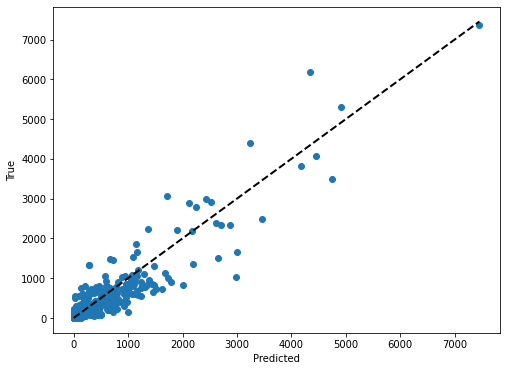

In [130]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [131]:
plt.figure(figsize=(8,6))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()

AttributeError: 'VotingRegressor' object has no attribute 'feature_importances_'

In [90]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

result = X_test_raw.copy(deep=False)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

# resultSkuShort = result.groupby(['SkuShort']).sum()
# resultSkuShort = resultSkuShort[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
# resultSkuShort['NewPredSalesHlDiff'] = resultSkuShort.NewPredSalesHl-resultSkuShort.OldPredSalesHl
# resultSkuShort = (100. * resultSkuShort).round(1).astype(str) + '%'

# print(resultSkuShort)

          OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year Week                                                 
2021 10            99.2%          63.9%             -35.3%
     11            92.7%          85.6%              -7.1%
     12            93.5%          95.3%               1.7%
     13            57.3%          66.7%               9.3%
     14            64.8%          96.8%              32.0%
     15            86.0%          90.6%               4.6%
     16            99.3%          79.7%             -19.6%
     17            94.1%          83.2%             -10.8%
     18            81.8%          85.1%               3.2%
     19            73.4%          89.4%              16.0%
     OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year                                                 
2021          82.6%          95.7%              13.2%


In [91]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

# X_labels = X.columns.tolist()
# forest_importances = pd.Series(result.importances_mean, index=X_labels)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

In [92]:
# from skater.core.explanations import Interpretation
# from skater.model import InMemoryModel

# examples_numpy = pd.concat([pd.DataFrame(X_train).sample(n=50), pd.DataFrame(X_test).sample(n=50)]).to_numpy()
# X_labels = X.columns.tolist()

# # wrap our base model with InMemoryModel instance
# annotated_model = InMemoryModel(
#     model.predict, 
#     examples = examples_numpy, 
#     model_type = 'regressor'
# )

# interpreter = Interpretation(examples_numpy, feature_names=X_labels)

In [93]:
#interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

In [94]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [95]:
# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

In [96]:
# import shap
# #shap.initjs()

# X100 = shap.utils.sample(train, 100)

# explainer = shap.Explainer(model)
# shap_values = explainer(X100)

# shap.plots.waterfall(shap_values[0])

In [97]:
# shap.plots.force(shap_values[0])

In [98]:
# shap.plots.force(shap_values)

In [99]:
# shap.plots.scatter(shap_values, color=shap_values)

In [100]:
# shap.plots.bar(shap_values)

In [101]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [102]:
result = X_test_raw.copy(deep=True)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [103]:
import joblib

dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/on-trade_model.joblib']

## Use model

In [104]:
# import joblib
# import os
# import numpy as np

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363